In [33]:
import json
import os
import re
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_mll
import gpytorch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'MFMOBO')))
from gskgpr import GaussianStringKernelGP
from seq2ascii import Seq2Ascii

In [34]:
gpytorch.settings.debug._set_state(True)

In [35]:
def load_json_res(pcc, data_dir):
    with open(f"{data_dir}/{pcc}_FEN.JSON") as f:
        rep = json.load(f)
    F_fen = rep["FE"]
    F_fen_err = rep["FE_error"]

    with open(f"{data_dir}/{pcc}_DEC.JSON") as f:
        rep = json.load(f)
    F_dec = rep["FE"]
    F_dec_err = rep["FE_error"]
    return {"PCC": [rep["PCC"]], "F_FEN": [float(F_fen)], "err_FEN": [float(F_fen_err)],
             "F_DEC": [float(F_dec)], "err_DEC": [float(F_dec_err)]}

def load_data(data_dir):
    PCC_list = []
    for folder in os.listdir(data_dir):
        if re.match("[A-Z]{5}_[A-Z]{3}", folder):
            PCC_list.append(folder.split("_")[0])

    PCC_list = set(PCC_list)
    data = []
    for pcc in PCC_list:
        try:
            data.append(pd.DataFrame(load_json_res(pcc, data_dir)))
        except:
            print(f"Skipping {pcc}.")

    data = pd.concat(data)
    data.reset_index(inplace=True, drop=True)
    return data

In [37]:
dataset = load_data("./MD_results/")
dataset["ddG_sen"] = -1*dataset.F_FEN
dataset["ddG_spe"] = dataset.F_DEC-dataset.F_FEN
dataset["sen_var"] = dataset.err_FEN
dataset["spe_var"] = np.sqrt(dataset.err_FEN**2 + dataset.err_DEC**2)
norm_sen = [dataset.ddG_sen.mean(), dataset.ddG_sen.std()]
norm_spe = [dataset.ddG_spe.mean(), dataset.ddG_spe.std()]
dataset.sen_var = dataset.sen_var/dataset.ddG_sen.std()
dataset.ddG_sen = (dataset.ddG_sen - dataset.ddG_sen.mean())/dataset.ddG_sen.std()
dataset.spe_var = dataset.spe_var/dataset.ddG_spe.std()
dataset.ddG_spe = (dataset.ddG_spe - dataset.ddG_spe.mean())/dataset.ddG_spe.std()

In [38]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
translator = Seq2Ascii("../../MFMOBO/AA.blosum62.pckl")

fspace = []
with open("../../gen_input_space/full_space.txt") as f:
    line = f.readline()
    while line:
        fspace.append(line.split()[0])
        line = f.readline()

translator.fit(fspace)

# Training and predicting on all the data

In [39]:
encoded_x = translator.encode_to_int(dataset.PCC.to_list()).to(device)
FE_sen = torch.tensor(dataset.ddG_sen.to_numpy()).float().to(device)
FE_sen_var = torch.tensor(dataset.sen_var.to_numpy()).float().to(device)
FE_spe = torch.tensor(dataset.ddG_spe.to_numpy()).float().to(device)
FE_spe_var = torch.tensor(dataset.spe_var.to_numpy()).float().to(device)
train_y = torch.cat([FE_sen.view(-1, 1), FE_spe.view(-1, 1)], dim=1)
err_y = torch.cat([FE_sen_var.view(-1, 1), FE_spe_var.view(-1, 1)], dim=1)

In [40]:
def initialize_model(train_x, train_y, err_y, translator):
    models = [
        GaussianStringKernelGP(train_x=train_x, train_y=train_y[:, 0], 
                            likelihood=FixedNoiseGaussianLikelihood(noise=err_y[:, 0]), 
                            translator=translator),
        GaussianStringKernelGP(train_x=train_x, train_y=train_y[:, 1],
                            likelihood=FixedNoiseGaussianLikelihood(noise=err_y[:, 1]), 
                            translator=translator)
    ]
    model = ModelListGP(*models).to(device)
    mll = SumMarginalLogLikelihood(model.likelihood, model).to(device)
    return model, mll

In [41]:
model, mll = initialize_model(encoded_x, train_y, err_y**2, translator) # Botorch uses variance (not error)
mll.train()
model.train()
fit_gpytorch_mll(mll)
model.eval()
mll.eval()

SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-1): 2 x GaussianStringKernelGP(
        (likelihood): FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
        (mean_module): ConstantMean()
        (covar_module): GenericStringKernel(
          (raw_sigma1_constraint): Positive()
          (raw_sigma2_constraint): Positive()
        )
      )
    )
    (likelihood): LikelihoodList(
      (likelihoods): ModuleList(
        (0-1): 2 x FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
      )
    )
  )
  (mlls): ModuleList(
    (0-1): 2 x ExactMarginalLogLikelihood(
      (likelihood): FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
      (model): GaussianStringKernelGP(
        

In [42]:
predict_Y_mean = model.posterior(encoded_x).mean.detach()
predict_Y_var = model.posterior(encoded_x).variance.detach()

/Users/arminsh/miniconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


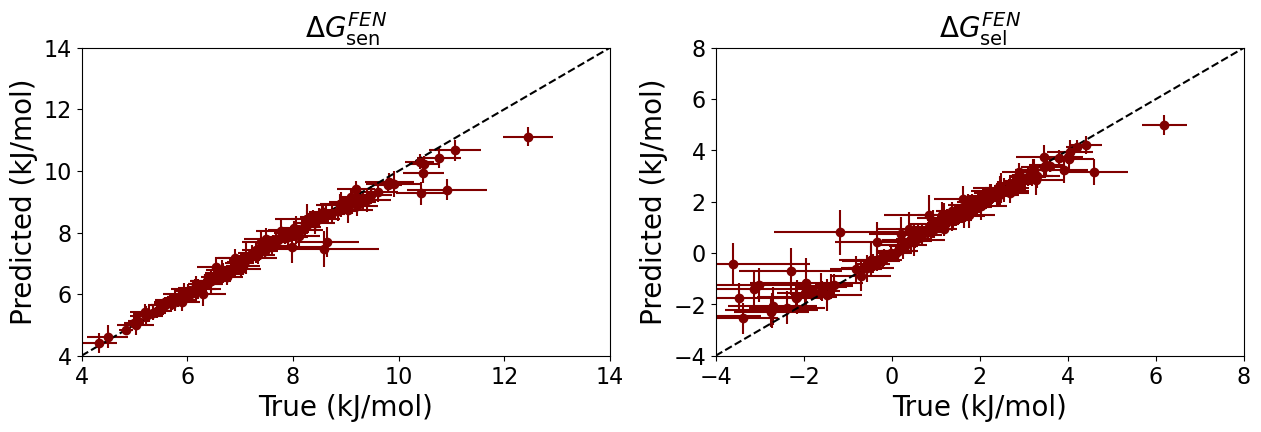

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

y_true = train_y[:, 0] * norm_sen[1] + norm_sen[0]
y_true_err = err_y[:, 0] * norm_sen[1]
y_pred = predict_Y_mean[:, 0] * norm_sen[1] + norm_sen[0]
y_pred_err = torch.sqrt(predict_Y_var[:, 0]) * norm_sen[1]

ax[0].errorbar(y_true, y_pred, xerr=y_true_err, yerr=y_pred_err, fmt='o', c="#800000")
ax[0].plot([4, 14], [4, 14], "k--")
ax[0].set_xlim(4, 14)
ax[0].set_ylim(4, 14)
ax[0].set_title(r"$\Delta G^{FEN}_{\text{sen}}$", fontsize=20)
ax[0].set_xlabel(r"True (kJ/mol)", fontsize=20)
ax[0].set_ylabel(r"Predicted (kJ/mol)", fontsize=20)
ax[0].tick_params(axis="both", which='major', labelsize=16)

y_true = train_y[:, 1] * norm_spe[1] + norm_spe[0]
y_true_err = err_y[:, 1] * norm_spe[1]
y_pred = predict_Y_mean[:, 1] * norm_spe[1] + norm_spe[0]
y_pred_err = torch.sqrt(predict_Y_var[:, 1]) * norm_spe[1]

ax[1].errorbar(y_true, y_pred, xerr=y_true_err, yerr=y_pred_err, fmt='o', c="#800000")
ax[1].plot([-4, 8], [-4, 8], "k--")
ax[1].set_xlim(-4, 8)
ax[1].set_ylim(-4, 8)
ax[1].set_title(r"$\Delta G^{FEN}_{\text{sel}}$", fontsize=20)
ax[1].set_xlabel(r"True (kJ/mol)", fontsize=20)
ax[1].set_ylabel(r"Predicted (kJ/mol)", fontsize=20)
ax[1].tick_params(axis="both", which='major', labelsize=16)
plt.show()

# Same analysis for binding free energies

In [63]:
dataset = load_data("./MD_results/")
norm_FEN = [dataset.F_FEN.mean(), dataset.F_FEN.std()]
norm_ACT = [dataset.F_DEC.mean(), dataset.F_DEC.std()]
dataset.err_FEN = dataset.err_FEN/norm_FEN[1]
dataset.F_FEN = (dataset.F_FEN - norm_FEN[0])/norm_FEN[1]
dataset.err_DEC = dataset.err_DEC/norm_ACT[1]
dataset.F_DEC = (dataset.F_DEC - norm_ACT[0])/norm_ACT[1]

In [64]:
encoded_x = translator.encode_to_int(dataset.PCC.to_list()).to(device)
FE_FEN = torch.tensor(dataset.F_FEN.to_numpy()).float().to(device)
FE_FEN_var = torch.tensor(dataset.err_FEN.to_numpy()).float().to(device)
FE_ACT = torch.tensor(dataset.F_DEC.to_numpy()).float().to(device)
FE_spe_var = torch.tensor(dataset.err_DEC.to_numpy()).float().to(device)
train_y = torch.cat([FE_FEN.view(-1, 1), FE_ACT.view(-1, 1)], dim=1)
err_y = torch.cat([FE_FEN_var.view(-1, 1), FE_spe_var.view(-1, 1)], dim=1)

In [65]:
model, mll = initialize_model(encoded_x, train_y, err_y**2, translator) # Botorch uses variance (not error)
mll.train()
model.train()
fit_gpytorch_mll(mll)
model.eval()
mll.eval()

SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-1): 2 x GaussianStringKernelGP(
        (likelihood): FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
        (mean_module): ConstantMean()
        (covar_module): GenericStringKernel(
          (raw_sigma1_constraint): Positive()
          (raw_sigma2_constraint): Positive()
        )
      )
    )
    (likelihood): LikelihoodList(
      (likelihoods): ModuleList(
        (0-1): 2 x FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
      )
    )
  )
  (mlls): ModuleList(
    (0-1): 2 x ExactMarginalLogLikelihood(
      (likelihood): FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
      (model): GaussianStringKernelGP(
        

In [66]:
predict_Y_mean = model.posterior(encoded_x).mean.detach()
predict_Y_var = model.posterior(encoded_x).variance.detach()

/Users/arminsh/miniconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


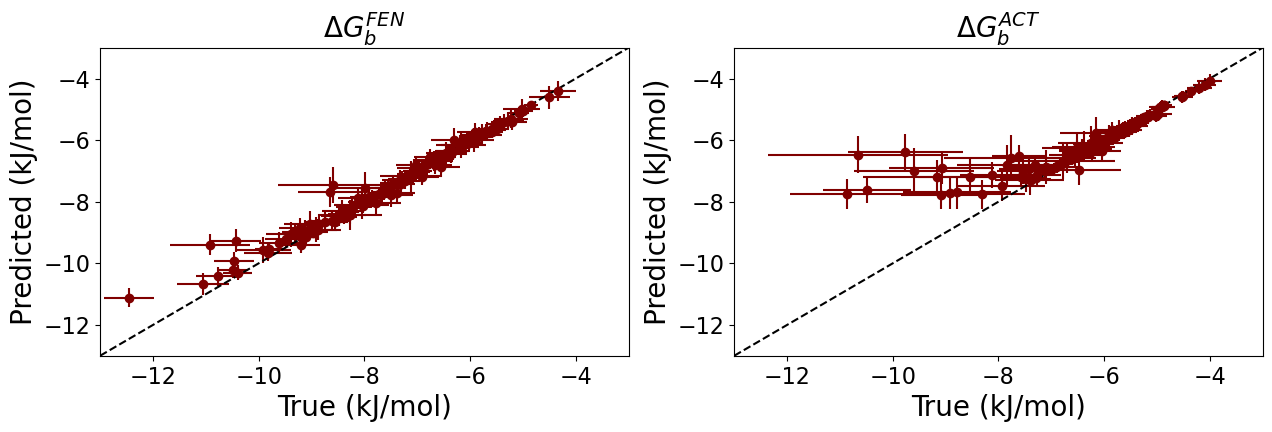

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

y_true = train_y[:, 0] * norm_FEN[1] + norm_FEN[0]
y_true_err = err_y[:, 0] * norm_FEN[1]
y_pred = predict_Y_mean[:, 0] * norm_FEN[1] + norm_FEN[0]
y_pred_err = torch.sqrt(predict_Y_var[:, 0]) * norm_FEN[1]

ax[0].errorbar(y_true, y_pred, xerr=y_true_err, yerr=y_pred_err, fmt='o', c="#800000")
ax[0].plot([-13, -3], [-13, -3], "k--")
ax[0].set_xlim(-13, -3)
ax[0].set_ylim(-13, -3)
ax[0].set_title(r"$\Delta G^{FEN}_{b}$", fontsize=20)
ax[0].set_xlabel(r"True (kJ/mol)", fontsize=20)
ax[0].set_ylabel(r"Predicted (kJ/mol)", fontsize=20)
ax[0].tick_params(axis="both", which='major', labelsize=16)

y_true = train_y[:, 1] * norm_ACT[1] + norm_ACT[0]
y_true_err = err_y[:, 1] * norm_ACT[1]
y_pred = predict_Y_mean[:, 1] * norm_ACT[1] + norm_ACT[0]
y_pred_err = torch.sqrt(predict_Y_var[:, 1]) * norm_ACT[1]

ax[1].errorbar(y_true, y_pred, xerr=y_true_err, yerr=y_pred_err, fmt='o', c="#800000")
ax[1].plot([-13, -3], [-13, -3], "k--")
ax[1].set_xlim(-13, -3)
ax[1].set_ylim(-13, -3)
ax[1].set_title(r"$\Delta G^{ACT}_{b}$", fontsize=20)
ax[1].set_xlabel(r"True (kJ/mol)", fontsize=20)
ax[1].set_ylabel(r"Predicted (kJ/mol)", fontsize=20)
ax[1].tick_params(axis="both", which='major', labelsize=16)
plt.show()

# Training on the one-to-last round and predicting on the last

In [87]:
dataset = load_data("./MD_results/")
dataset["ddG_sen"] = -1*dataset.F_FEN
dataset["ddG_spe"] = dataset.F_DEC-dataset.F_FEN
dataset["sen_var"] = dataset.err_FEN
dataset["spe_var"] = np.sqrt(dataset.err_FEN**2 + dataset.err_DEC**2)

dataset_test = dataset[dataset.PCC.isin(["FHVPY", "GFHVY", "HHWTW", "FTFGF", "FTHGF", "FTTGF"])].copy()


dataset_train = dataset.drop(index=dataset_test.index)
norm_sen = [dataset_train.ddG_sen.mean(), dataset_train.ddG_sen.std()]
norm_spe = [dataset_train.ddG_spe.mean(), dataset_train.ddG_spe.std()]
dataset_train.sen_var = dataset_train.sen_var/dataset_train.ddG_sen.std()
dataset_train.ddG_sen = (dataset_train.ddG_sen - dataset_train.ddG_sen.mean())/dataset_train.ddG_sen.std()
dataset_train.spe_var = dataset_train.spe_var/dataset_train.ddG_spe.std()
dataset_train.ddG_spe = (dataset_train.ddG_spe - dataset_train.ddG_spe.mean())/dataset_train.ddG_spe.std()

In [88]:
encoded_x = translator.encode_to_int(dataset_train.PCC.to_list()).to(device)
FE_sen = torch.tensor(dataset_train.ddG_sen.to_numpy()).float().to(device)
FE_sen_var = torch.tensor(dataset_train.sen_var.to_numpy()).float().to(device)
FE_spe = torch.tensor(dataset_train.ddG_spe.to_numpy()).float().to(device)
FE_spe_var = torch.tensor(dataset_train.spe_var.to_numpy()).float().to(device)
train_y = torch.cat([FE_sen.view(-1, 1), FE_spe.view(-1, 1)], dim=1)
err_y = torch.cat([FE_sen_var.view(-1, 1), FE_spe_var.view(-1, 1)], dim=1)

In [89]:
model, mll = initialize_model(encoded_x, train_y, err_y**2, translator) # Botorch uses variance (not error)
mll.train()
model.train()
fit_gpytorch_mll(mll)
model.eval()
mll.eval()

SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-1): 2 x GaussianStringKernelGP(
        (likelihood): FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
        (mean_module): ConstantMean()
        (covar_module): GenericStringKernel(
          (raw_sigma1_constraint): Positive()
          (raw_sigma2_constraint): Positive()
        )
      )
    )
    (likelihood): LikelihoodList(
      (likelihoods): ModuleList(
        (0-1): 2 x FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
      )
    )
  )
  (mlls): ModuleList(
    (0-1): 2 x ExactMarginalLogLikelihood(
      (likelihood): FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
      (model): GaussianStringKernelGP(
        

In [90]:
test_x = translator.encode_to_int(dataset_test.PCC.to_list()).to(device)
predict_Y_mean = model.posterior(test_x).mean.detach()
predict_Y_var = model.posterior(test_x).variance.detach()

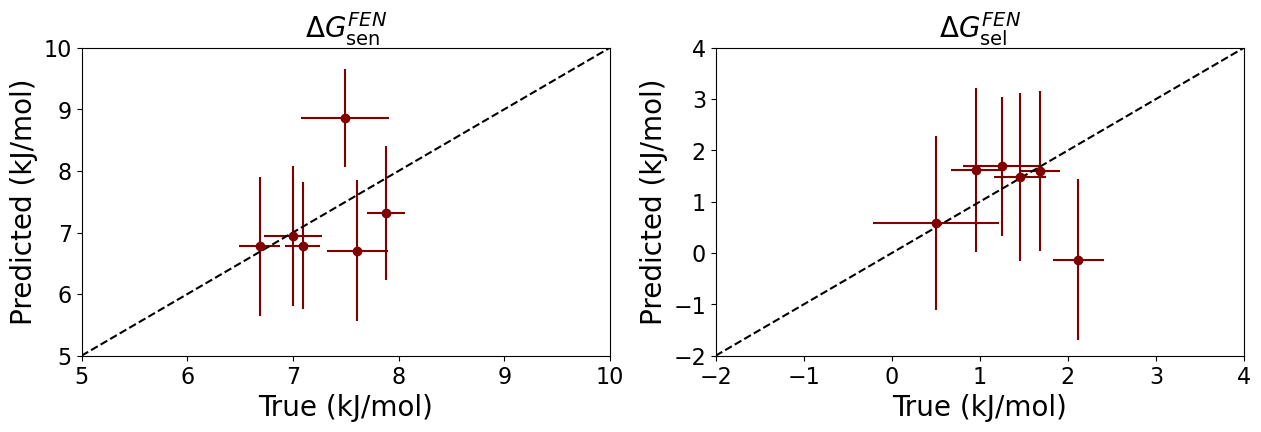

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

y_true = dataset_test.ddG_sen
y_true_err = dataset_test.sen_var
y_pred = predict_Y_mean[:, 0] * norm_sen[1] + norm_sen[0]
y_pred_err = torch.sqrt(predict_Y_var[:, 0]) * norm_sen[1]

ax[0].errorbar(y_true, y_pred, xerr=y_true_err, yerr=y_pred_err, fmt='o', c="#800000")
ax[0].plot([5, 10], [5, 10], "k--")
ax[0].set_xlim(5, 10)
ax[0].set_ylim(5, 10)
ax[0].set_title(r"$\Delta G^{FEN}_{\text{sen}}$", fontsize=20)
ax[0].set_xlabel(r"True (kJ/mol)", fontsize=20)
ax[0].set_ylabel(r"Predicted (kJ/mol)", fontsize=20)
ax[0].tick_params(axis="both", which='major', labelsize=16)

y_true = dataset_test.ddG_spe
y_true_err = dataset_test.spe_var
y_pred = predict_Y_mean[:, 1] * norm_spe[1] + norm_spe[0]
y_pred_err = torch.sqrt(predict_Y_var[:, 1]) * norm_spe[1]

ax[1].errorbar(y_true, y_pred, xerr=y_true_err, yerr=y_pred_err, fmt='o', c="#800000")
ax[1].plot([-2, 4], [-2, 4], "k--")
ax[1].set_xlim(-2, 4)
ax[1].set_ylim(-2, 4)
ax[1].set_title(r"$\Delta G^{FEN}_{\text{sel}}$", fontsize=20)
ax[1].set_xlabel(r"True (kJ/mol)", fontsize=20)
ax[1].set_ylabel(r"Predicted (kJ/mol)", fontsize=20)
ax[1].tick_params(axis="both", which='major', labelsize=16)
plt.show()